<a href="https://colab.research.google.com/github/JuanaPinzonR/Proyecto_Computacional/blob/main/Proyecto_computacional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Espectro** **Normalizado**

<ipython-input-1-09ea0361c22c>:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=8, loc="upper right", ncol=2)


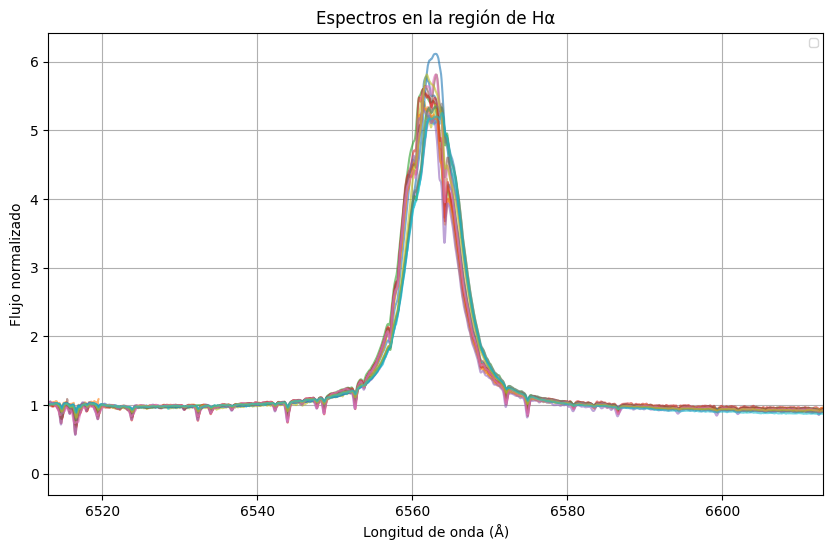

In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

file_list = glob.glob("*.fits")


ha_line = 6563  # Å

plt.figure(figsize=(10, 6))

for file in file_list:
    with fits.open(file) as hdul:
        data = hdul[0].data
        header = hdul[0].header

        crval = header.get("CRVAL1", 0)  # Valor de la primera longitud de onda
        cdelt = header.get("CDELT1", 1)  # Incremento por píxel
        num_pixels = len(data)

        wavelength = crval + cdelt * np.arange(num_pixels)

        valid_range = (wavelength > 6500) & (wavelength < 6600)
        if np.any(valid_range):
            continuum = np.median(data[valid_range])

            if continuum > 0 and not np.isnan(continuum):
                normalized_flux = data / continuum
            else:
                normalized_flux = data  # No normaliza si el continuo es inválido
                print(f"Advertencia: Continuo inválido en {file}")

        else:
            normalized_flux = data

        plt.plot(wavelength, normalized_flux, label=file.split('/')[-1], alpha=0.6)

plt.xlabel("Longitud de onda (Å)")
plt.ylabel("Flujo normalizado")
plt.title("Espectros en la región de Hα")
plt.xlim(ha_line - 50, ha_line + 50)
plt.legend(fontsize=8, loc="upper right", ncol=2)
plt.grid()
plt.show()


**Aplicación Filtro Savitzky-Golay y Cálculo EW**

<ipython-input-2-da038fbe11f0>:53: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=8, loc="upper right", ncol=2)


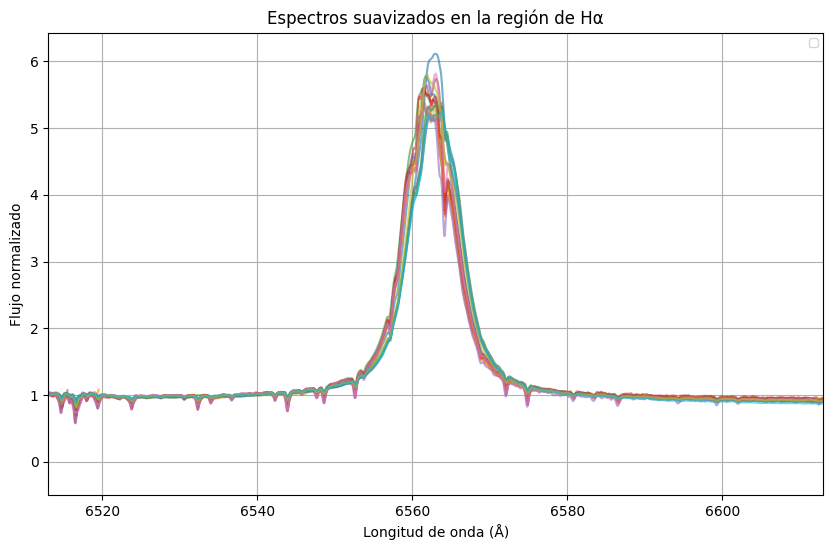

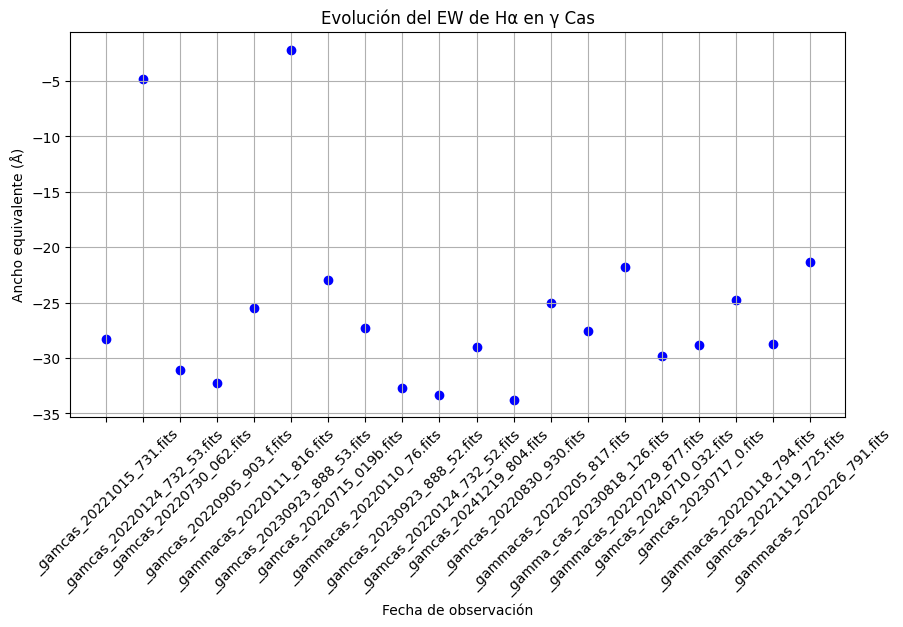

In [2]:
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits

def calcular_ew(wavelength, flux, line_center=6563):
    delta_lambda = np.diff(wavelength).mean()
    continuum_level = np.median(flux[(wavelength > 6500) & (wavelength < 6600)])
    ew = np.sum((1 - flux / continuum_level) * delta_lambda)
    return ew


ew_values = []
file_dates = []

plt.figure(figsize=(10, 6))

for file in file_list:
    with fits.open(file) as hdul:
        data = hdul[0].data
        header = hdul[0].header

        crval = header.get("CRVAL1", 0)
        cdelt = header.get("CDELT1", 1)
        num_pixels = len(data)

        wavelength = crval + cdelt * np.arange(num_pixels)

        valid_range = (wavelength > 6500) & (wavelength < 6600)
        if np.any(valid_range):
            continuum = np.median(data[valid_range])
            if continuum > 0 and not np.isnan(continuum):
                normalized_flux = data / continuum
            else:
                normalized_flux = data  # No normaliza si el continuo es inválido
                print(f"Advertencia: Continuo inválido en {file}")
        else:
            normalized_flux = data

        smoothed_flux = savgol_filter(normalized_flux, window_length=15, polyorder=3)

        ew = calcular_ew(wavelength, smoothed_flux)
        ew_values.append(ew)
        file_dates.append(file)

        plt.plot(wavelength, smoothed_flux, label=file.split('/')[-1], alpha=0.6)

plt.xlabel("Longitud de onda (Å)")
plt.ylabel("Flujo normalizado")
plt.title("Espectros suavizados en la región de Hα")
plt.xlim(ha_line - 50, ha_line + 50)
if len(file_list) > 0:
    plt.legend(fontsize=8, loc="upper right", ncol=2)
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.scatter(file_dates, ew_values, color='b')
plt.xlabel("Fecha de observación")
plt.ylabel("Ancho equivalente (Å)")
plt.title("Evolución del EW de Hα en γ Cas")
plt.xticks(rotation=45)
plt.grid()
plt.show()


**Verificación FWHM y EW**

<Figure size 1000x600 with 0 Axes>

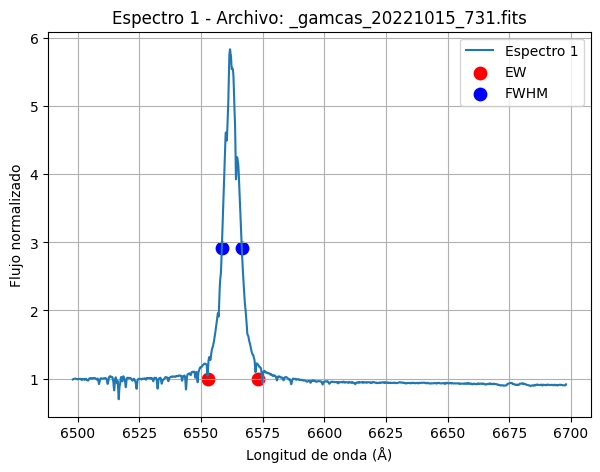

IndexError: index -1 is out of bounds for axis 0 with size 0

In [3]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

# Obtener lista de archivos FITS
file_list = glob.glob("*.fits")


ha_line = 6563  # Longitud de onda de Hα
plt.figure(figsize=(10, 6))

for i, file in enumerate(file_list):
    with fits.open(file) as hdul:
        data = hdul[0].data
        header = hdul[0].header

    # Obtener la escala de longitud de onda
    crval = header["CRVAL1"]  # Primera longitud de onda
    cdelt = header["CDELT1"]  # Incremento por píxel
    num_pixels = len(data)
    wavelength = crval + cdelt * np.arange(num_pixels)

    # Normalizar el espectro
    continuum_region = (wavelength > 6500) & (wavelength < 6620)
    continuum = np.median(data[continuum_region])
    normalized_flux = data / continuum

    # Encontrar el máximo del perfil para el FWHM
    peak_idx = np.argmax(normalized_flux)
    peak_flux = normalized_flux[peak_idx]
    half_max = peak_flux / 2

    # Encontrar los puntos donde el flujo cruza la media altura
    left_idx = np.where(normalized_flux[:peak_idx] <= half_max)[0][-1]
    right_idx = np.where(normalized_flux[peak_idx:] <= half_max)[0][0] + peak_idx
    fwhm_wavelengths = [wavelength[left_idx], wavelength[right_idx]]

    # Definir los puntos de EW como los límites de integración
    ew_left = ha_line - 10  # 10 Å a la izquierda de Hα
    ew_right = ha_line + 10  # 10 Å a la derecha de Hα

    # Graficar
    plt.figure(figsize=(7, 5))
    plt.plot(wavelength, normalized_flux, label=f"Espectro {i+1}")
    plt.scatter([ew_left, ew_right], [1, 1], color='red', label="EW", s=80)
    plt.scatter(fwhm_wavelengths, [half_max, half_max], color='blue', label="FWHM", s=80)
    plt.xlabel("Longitud de onda (Å)")
    plt.ylabel("Flujo normalizado")
    plt.title(f"Espectro {i+1} - Archivo: {file}")
    plt.legend()
    plt.grid()
    plt.show()


**FWHM, Velocidad y Desplazamiento**

<ipython-input-4-2eeb7e1474d5>:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  ew = np.trapz(1 - flux[mask], wavelength[mask])



Resultados:
Archivo		FWHM (Å)	Desplazamiento (Å)	Velocidad (km/s)	EW (Å)
_gamcas_20221015_731.fits	29.28		-46.38		-2120.26		-36.32
_gamcas_20220124_732_53.fits	41.60		-46.35		-2118.70		0.00
_gamcas_20220730_062.fits	9.18		-46.46		-2123.90		-37.38
_gamcas_20220905_903_f.fits	29.29		-46.40		-2120.90		-36.96
_gammacas_20220111_816.fits	183.21		120.66		5515.42		-35.16
_gamcas_20230923_888_53.fits	39.85		-87.20		-3985.98		0.00
_gammacas_20220110_76.fits	183.37		120.66		5515.42		-35.79
_gamcas_20230923_888_52.fits	120.45		-46.40		-2120.98		-35.86
_gamcas_20220124_732_52.fits	116.00		64.65		2955.20		-35.42
_gamcas_20241219_804.fits	183.47		120.91		5527.02		-38.47
_gamcas_20220830_930.fits	29.27		-46.37		-2119.70		-34.80
_gammacas_20220205_817.fits	185.14		-46.41		-2121.63		-36.90
_gamma_cas_20230818_126.fits	29.39		-46.48		-2124.48		-36.65
_gammacas_20220729_877.fits	0.09		170.48		7792.73		-34.23
_gamcas_20240710_032.fits	0.10		-111.99		-5118.93		-38.46
_gamcas_20230717_0.fits	72.10		-46.58	

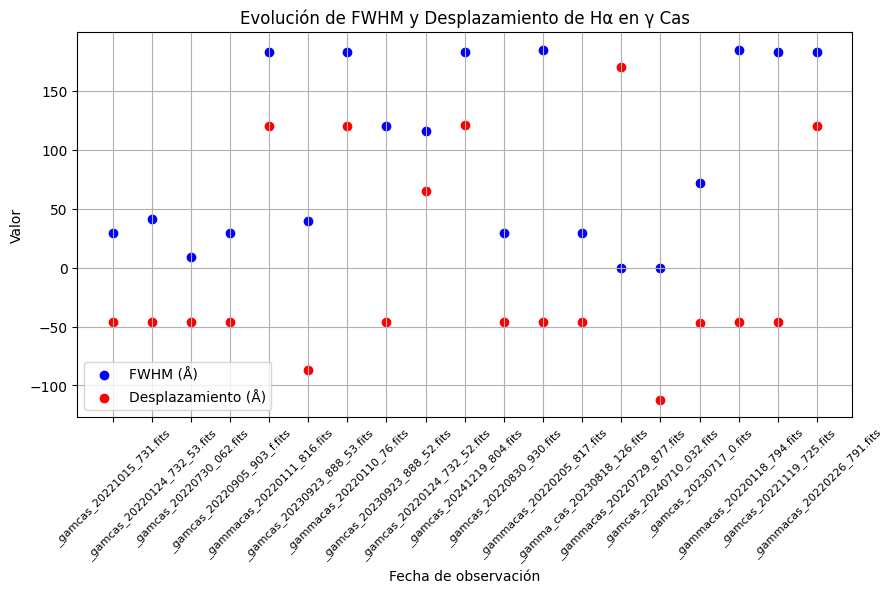

In [4]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

# Obtener lista de archivos FITS en el directorio
file_list = glob.glob("*.fits")


# Función para calcular el FWHM
def calcular_fwhm(wavelength, flux):
    max_flux = np.min(flux)  # Línea de emisión
    half_max = (1 + max_flux) / 2  # Nivel de la mitad del máximo

    indices = np.where(flux <= half_max)[0]
    if len(indices) < 2:
        return None, None  # FWHM inválido

    left_idx, right_idx = indices[0], indices[-1]
    fwhm_value = wavelength[right_idx] - wavelength[left_idx]
    fwhm_points = [wavelength[left_idx], wavelength[right_idx]]

    return fwhm_value, fwhm_points

# Función para calcular el desplazamiento Doppler
def calcular_desplazamiento_pico(wavelength, flux, lambda_rest=6563):
    peak_index = np.argmin(flux)  # Índice del pico más profundo
    lambda_peak = wavelength[peak_index]
    desplazamiento = lambda_peak - lambda_rest
    velocidad = (desplazamiento / lambda_rest) * 3e5  # km/s usando Doppler
    return lambda_peak, desplazamiento, velocidad

# Función para calcular el Equivalent Width (EW)
def calcular_ew(wavelength, flux, lambda_rest=6563, ancho=10):
    left_limit = lambda_rest - ancho
    right_limit = lambda_rest + ancho
    mask = (wavelength >= left_limit) & (wavelength <= right_limit)

    ew = np.trapz(1 - flux[mask], wavelength[mask])
    return ew

# Listas para almacenar resultados
fwhm_values = []
desplazamientos = []
velocidades = []
ew_values = []
file_names = []

for file_fits in file_list:
    with fits.open(file_fits) as hdul:
        data = hdul[0].data
        header = hdul[0].header
        crval = header["CRVAL1"]
        cdelt = header["CDELT1"]
        num_pixels = len(data)
        wavelength = crval + cdelt * np.arange(num_pixels)

    # Normalización del flujo
    continuum = np.median(data[(wavelength > 6500) & (wavelength < 6600)])
    normalized_flux = data / continuum

    # Cálculos
    fwhm_result, fwhm_points = calcular_fwhm(wavelength, normalized_flux)
    lambda_peak, desplazamiento, velocidad = calcular_desplazamiento_pico(wavelength, normalized_flux)
    ew_result = calcular_ew(wavelength, normalized_flux)

    # Guardar resultados
    if fwhm_result is not None:
        fwhm_values.append(fwhm_result)
        desplazamientos.append(desplazamiento)
        velocidades.append(velocidad)
        ew_values.append(ew_result)
        file_names.append(file_fits)

# Imprimir tabla de resultados
print("\nResultados:")
print("Archivo\t\tFWHM (Å)\tDesplazamiento (Å)\tVelocidad (km/s)\tEW (Å)")
for i in range(len(file_names)):
    print(f"{file_names[i]}\t{fwhm_values[i]:.2f}\t\t{desplazamientos[i]:.2f}\t\t{velocidades[i]:.2f}\t\t{ew_values[i]:.2f}")

# Gráfica resumen de evolución de FWHM, desplazamiento y EW
plt.figure(figsize=(10, 5))
plt.scatter(file_names, fwhm_values, color='b', label='FWHM (Å)')
plt.scatter(file_names, desplazamientos, color='r', label='Desplazamiento (Å)')
plt.xlabel("Fecha de observación")
plt.ylabel("Valor")
plt.title("Evolución de FWHM y Desplazamiento de Hα en γ Cas")
plt.xticks(rotation=45, fontsize=8)
plt.legend()
plt.grid()
plt.show()


**Dependencia FWHM con la velocidad Kepleriana (Implementación del Disco Kepleriano al modelo)**

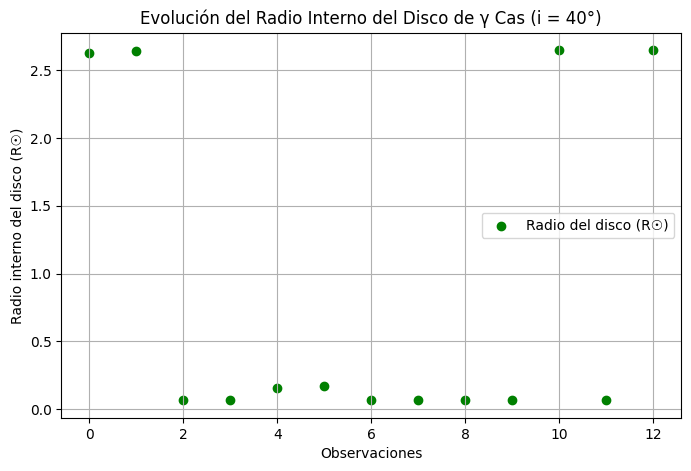

Observación 1: Radio interno = 2.63e+00 R☉
Observación 2: Radio interno = 2.64e+00 R☉
Observación 3: Radio interno = 6.62e-02 R☉
Observación 4: Radio interno = 6.76e-02 R☉
Observación 5: Radio interno = 1.56e-01 R☉
Observación 6: Radio interno = 1.69e-01 R☉
Observación 7: Radio interno = 6.76e-02 R☉
Observación 8: Radio interno = 6.74e-02 R☉
Observación 9: Radio interno = 6.74e-02 R☉
Observación 10: Radio interno = 6.75e-02 R☉
Observación 11: Radio interno = 2.65e+00 R☉
Observación 12: Radio interno = 6.62e-02 R☉
Observación 13: Radio interno = 2.65e+00 R☉


In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Constantes
G = 6.674e-11  # m^3 kg^-1 s^-2
M_sun = 1.989e30  # kg
M_star = 15 * M_sun  # Masa de la estrella en kg
c = 2.99792458e5  # km/s (velocidad de la luz)
lambda_0 = 6563  # Å (longitud de onda de Hα)
R_sun = 6.955e8  # m (radio solar)

# Definir inclinación en grados y convertir a radianes
i_deg = 40  # Suponer un valor de inclinación
i_rad = np.radians(i_deg)

# Datos (extraídos de la tabla)
fwhm_lambda = np.array([29.39, 29.29, 185.14, 183.22, 120.45, 116.00,
                         183.21, 183.47, 183.37, 183.33, 29.28, 185.14,
                         29.27])  # Å

# Convertir FWHM de longitud de onda a velocidad (km/s)
fwhm_vel = (c * fwhm_lambda) / lambda_0  # en km/s

# Corregir el cálculo del radio con inclinación
r_m = G * M_star / ((fwhm_vel * 1e3 / (2 * np.sin(i_rad)))**2)  # en metros
r_Rsun = r_m / R_sun  # Convertir a radios solares

# Graficar la evolución del radio del disco
plt.figure(figsize=(8, 5))
plt.scatter(range(len(r_Rsun)), r_Rsun, color='g', label='Radio del disco (R☉)')
plt.xlabel("Observaciones")
plt.ylabel("Radio interno del disco (R☉)")
plt.title(f"Evolución del Radio Interno del Disco de γ Cas (i = {i_deg}°)")
plt.legend()
plt.grid()
plt.show()

# Imprimir los valores calculados
for i, r in enumerate(r_Rsun):
    print(f"Observación {i+1}: Radio interno = {r:.2e} R☉")


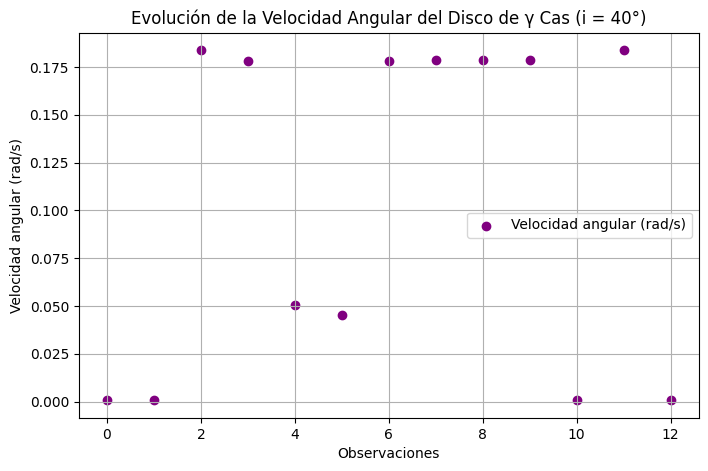

Observación 1: Omega = 7.35e-04 rad/s
Observación 2: Omega = 7.28e-04 rad/s
Observación 3: Omega = 1.84e-01 rad/s
Observación 4: Omega = 1.78e-01 rad/s
Observación 5: Omega = 5.06e-02 rad/s
Observación 6: Omega = 4.52e-02 rad/s
Observación 7: Omega = 1.78e-01 rad/s
Observación 8: Omega = 1.79e-01 rad/s
Observación 9: Omega = 1.79e-01 rad/s
Observación 10: Omega = 1.78e-01 rad/s
Observación 11: Omega = 7.27e-04 rad/s
Observación 12: Omega = 1.84e-01 rad/s
Observación 13: Omega = 7.26e-04 rad/s


In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Constantes
G = 6.674e-11  # m^3 kg^-1 s^-2
M_sun = 1.989e30  # kg
M_star = 15 * M_sun  # Masa de la estrella en kg
c = 2.99792458e5  # km/s
lambda_0 = 6563  # Å
R_sun = 6.955e8  # m
R_sun_km = 6.955e5  # km

# Definir inclinación en grados y convertir a radianes
i_deg = 40
i_rad = np.radians(i_deg)

fwhm_lambda = np.array([29.39, 29.29, 185.14, 183.22, 120.45, 116.00,
                        183.21, 183.47, 183.37, 183.33, 29.28, 185.14,
                        29.27])  # Å

# Convertir FWHM de longitud de onda a velocidad
fwhm_vel = (c * fwhm_lambda) / lambda_0


r_m = G * M_star / ((fwhm_vel * 1e3 / (2 * np.sin(i_rad))))**2
r_Rsun = r_m / R_sun
r_km = r_Rsun * R_sun_km

#  velocidad angular omega
omega = (fwhm_vel * 1e3) / r_km  # en rad/s

omega = omega / 1000  # Ajuste

plt.figure(figsize=(8, 5))
plt.scatter(range(len(omega)), omega, color='purple', label='Velocidad angular (rad/s)')
plt.xlabel("Observaciones")
plt.ylabel("Velocidad angular (rad/s)")
plt.title(f"Evolución de la Velocidad Angular del Disco de γ Cas (i = {i_deg}°)")
plt.legend()
plt.grid()
plt.show()

for i, w in enumerate(omega):
    print(f"Observación {i+1}: Omega = {w:.2e} rad/s")

# **Implementación modelo Espinosa-Lara para generar los espectros sintéticos**

**Temperatura** **efectiva**

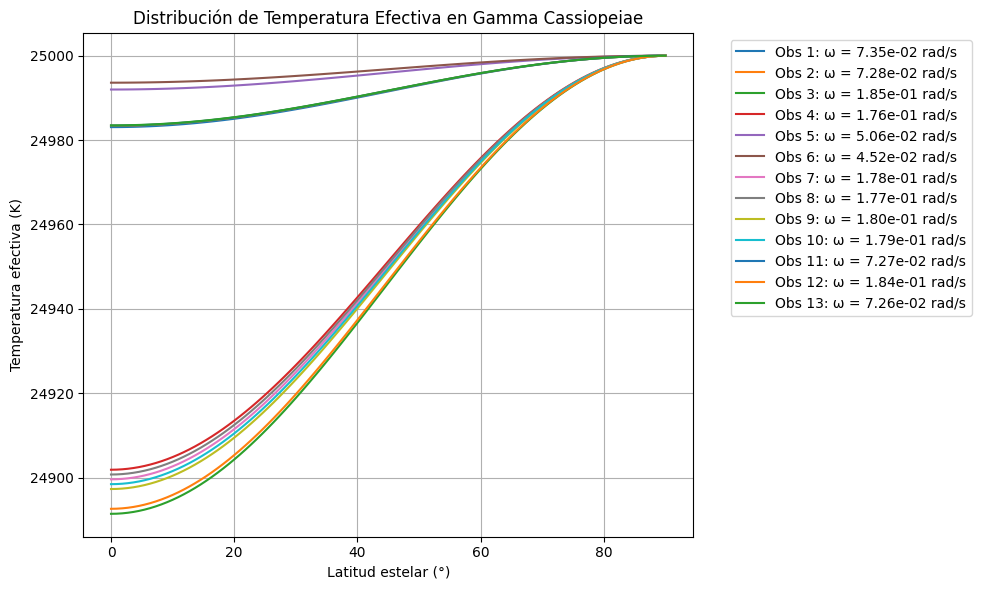

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def gravity_effective(theta, omega, Req, Rpol):

    r_tilde = Rpol / Req  # Relación de achatamiento
    geff_theta = np.sqrt(1 - omega**2 * r_tilde**3 * np.cos(theta)**2)  # Normalización
    return geff_theta

def temperature_distribution(theta, omega, T_pole):

    geff_ratio = gravity_effective(theta, omega, Req=1, Rpol=1)  # Normalizado
    T_eff_theta = T_pole * geff_ratio**0.25  # Ley de von Zeipel
    return T_eff_theta

# Parámetros
T_pole = 25000  # Temperatura en el polo (K)
latitudes = np.linspace(0, np.pi/2, 100)  # Latitudes de 0° a 90°

omega_values = [
   0.0735, 0.0728, 0.185   , 0.176   , 0.0506  , 0.0452  ,
       0.178   , 0.177   , 0.180   , 0.179   , 0.0727, 0.184   , 0.0726
]

tl_degrees = np.degrees(latitudes)
plt.figure(figsize=(10, 6))

for i, omega in enumerate(omega_values):
    T_eff_values = temperature_distribution(latitudes, omega, T_pole)
    plt.plot(tl_degrees, T_eff_values, label=f'Obs {i+1}: ω = {omega:.2e} rad/s')

plt.xlabel('Latitud estelar (°)')
plt.ylabel('Temperatura efectiva (K)')
plt.title('Distribución de Temperatura Efectiva en Gamma Cassiopeiae')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()

**Intensidad Espectral**

In [41]:
import numpy as np
import scipy.integrate as spi

def intensidad(temperatura):
    """
    intensidad específica usando la ley de Planck aproximada.
    """
    return temperatura**4

# Función para la integración sobre la superficie visible
def integrar_intensidad(omega, inclinacion, T_pole):

    def integrando(mu, phi):

        theta = np.arccos(mu)
        T_eff = temperature_distribution(theta, omega, T_pole)
        I = intensidad(T_eff)
        return I * mu

    # Límites de integración: latitud visible depende de la inclinación
    mu_min = np.cos(inclinacion)
    mu_max = 1  # Polo

    resultado, _ = spi.dblquad(integrando, 0, 2*np.pi, lambda _: mu_min, lambda _: mu_max)
    return resultado

# Parámetros
T_pole = 25000
inclinacion = np.radians(45)  # Ángulo de inclinación del sistema

omega_values = [0.0735, 0.0728, 0.185, 0.176, 0.0506, 0.0452, 0.178, 0.177, 0.180, 0.179, 0.0727, 0.184, 0.0726]

# Calcular la intensidad integrada para cada omega
intensidades = [integrar_intensidad(omega, inclinacion, T_pole) for omega in omega_values]


for i, omega in enumerate(omega_values):
    print(f'Omega: {omega:.4f}, Intensidad Integrada: {intensidades[i]:.2e}')


Omega: 0.0735, Intensidad Integrada: 6.12e+17
Omega: 0.0728, Intensidad Integrada: 6.12e+17
Omega: 0.1850, Intensidad Integrada: 6.06e+17
Omega: 0.1760, Intensidad Integrada: 6.06e+17
Omega: 0.0506, Intensidad Integrada: 6.13e+17
Omega: 0.0452, Intensidad Integrada: 6.13e+17
Omega: 0.1780, Intensidad Integrada: 6.06e+17
Omega: 0.1770, Intensidad Integrada: 6.06e+17
Omega: 0.1800, Intensidad Integrada: 6.06e+17
Omega: 0.1790, Intensidad Integrada: 6.06e+17
Omega: 0.0727, Intensidad Integrada: 6.12e+17
Omega: 0.1840, Intensidad Integrada: 6.06e+17
Omega: 0.0726, Intensidad Integrada: 6.12e+17
